<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Download and visualise BGC data over an ocean region

This notebook shows how to:
- download BGC-Argo data for a space/time domain
- plot a map with floats trajectory
- plot BGC data

## Import and set-up

In [1]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean
import xarray as xr
import pandas as pd
xr.set_options(display_expand_attrs = False)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

## Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [3]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-35, -30, 62, 64, 0, 2000, '2010-01', '2024-12']

## Get more info about this region using the ArgoIndex

In [4]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (364223 records)
Searched: False

In [5]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure axis BOX limits
idx = idx.query.box(index_BOX) # Had to replace this with something new as argopy has been updated

In [6]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP700',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [7]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
#[bgc_params.remove(p) for p in ['PH_IN_SITU_TOTAL', 'BISULFIDE', 'CDOM']]  # Remove core variables from the list
bgc_params

['BBP700',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [8]:
# How many different floats in the region:
len(idx.read_wmo())

39

## Load all data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [9]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='phy', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...
CPU times: user 46.5 s, sys: 2.43 s, total: 48.9 s
Wall time: 4min 30s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo data fetcher for a space/time region
🗺  Domain: [x=-35.00/-30.00; y=62.00/64.00; z=0.0/2000.0; t=2010-01-01/2024-12-01]
🔗 API: https://erddap.ifremer.fr/erddap
🏄 User mode: expert
🟡+🔵 Dataset: phy
🌤  Performances: cache=False, parallel=True [thread]

In [10]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 572MB
Dimensions:                   (N_POINTS: 500268)
Coordinates:
    LATITUDE                  (N_POINTS) float64 4MB 63.24 63.24 ... 62.58 62.58
    LONGITUDE                 (N_POINTS) float64 4MB -32.41 -32.41 ... -31.33
    TIME                      (N_POINTS) datetime64[ns] 4MB 2010-01-04T04:33:...
  * N_POINTS                  (N_POINTS) int64 4MB 0 1 2 ... 500266 500267
Data variables: (12/23)
    CONFIG_MISSION_NUMBER     (N_POINTS) int64 4MB 2 2 2 2 2 ... 14 14 14 14 14
    CYCLE_NUMBER              (N_POINTS) int64 4MB 55 55 55 55 ... 95 95 95 95
    DATA_MODE                 (N_POINTS) <U1 2MB 'D' 'D' 'D' 'D' ... 'R' 'R' 'R'
    DIRECTION                 (N_POINTS) <U1 2MB 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER           (N_POINTS) int64 4MB 6900492 6900492 ... 6904240
    POSITION_QC               (N_POINTS) int64 4MB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    ...                        ...
    TEMP_ADJUSTED             (N_POINTS) float32 2MB 5.845 5.846 ... nan nan
    TEMP_ADJUSTED_ERROR       (N_POINTS) float32 2MB 0.002 0.002 ... nan nan
    TEMP_ADJUSTED_QC          (N_POINTS) int64 4MB 1 1 1 1 1 1 1 ... 0 0 0 0 0 0
    TEMP_QC                   (N_POINTS) int64 4MB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    TIME_QC                   (N_POINTS) int64 4MB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1
    VERTICAL_SAMPLING_SCHEME  (N_POINTS) <U245 490MB 'Primary sampling: avera...
Attributes: (7)

In [11]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(500268) ~ N_PROF(1594) x N_LEVELS(1016)

In [12]:
import polars as pl
variables = ['TIME', 'LONGITUDE', 'LATITUDE', 'PRES', 'TEMP', 'PSAL', 'PSAL_QC', 'CHLA_ADJUSTED', 'CHLA_ADJUSTED_QC', 'BBP700_ADJUSTED', 'BBP700_ADJUSTED_QC']
df = pl.DataFrame(ds.to_dataframe()) 

Had to change directoy stuff


In [13]:
# Create directories to save the data
rootdir = '../data/argo/'
paquet_dir = '../data/argo/argo_pq'

import os
if 'argo' not in os.listdir('../data/'):
    os.mkdir(rootdir)
if 'argo_pq' not in os.listdir(rootdir):
    os.mkdir(paquet_dir)

df.write_parquet('../data/argo/argo_pq/icb_floats_table.parquet')

In [14]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

,date,latitude,longitude,wmo,cyc
0,2013-06-25 03:56:00,63.199077,-30.473118,6901489,6
1,2013-06-16 22:06:00,62.753158,-30.291982,6901489,1
2,2013-06-17 14:22:00,62.797107,-30.177502,6901486,2
3,2013-06-17 00:50:00,62.756952,-30.257498,6901486,1
4,2013-06-17 15:43:00,62.801108,-30.183217,6901485,2
...,...,...,...,...,...
1589,2024-10-21 14:09:50,63.688020,-31.545643,6904240,91
1590,2024-10-31 14:11:51,63.652669,-32.082915,6904240,92
1591,2024-11-10 14:11:50,63.321430,-32.013991,6904240,93
1592,2024-11-20 14:11:52,62.695909,-32.258505,6904240,94


## Make a map with all floats trajectory

Rq: we could have done this without downloading the data by working directly with the ArgoIndex

```python
scatter_map(idx.to_dataframe(), set_global=False);
```

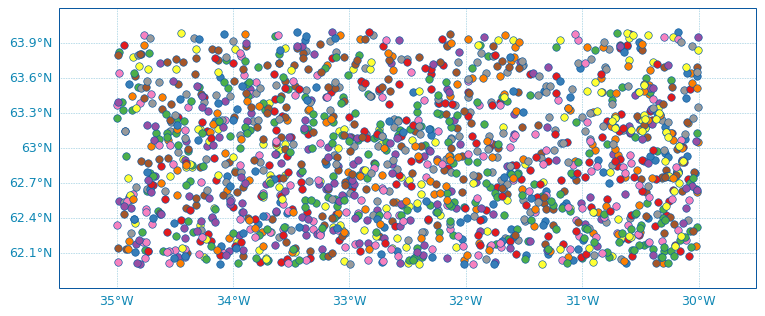

In [15]:
# But here, we use the index retrieved with the DataFetcher:
scatter_map(df, traj=False, set_global=False, legend=False);

## Make a map with one BGC parameter data mode

We can also make a scatter map with one BGC parameter data mode.

In [16]:
# Randomly select one BGC parameter to work with:
a_param = bgc_params[np.random.randint(len(bgc_params))]
a_param

'CHLA'

In [17]:
# Get more verbose information about this parameter (usefull for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==a_param].iloc[0].to_dict()
param_info

{'altLabel': 'CHLA',
 'prefLabel': 'Chlorophyll-A',
 'definition': 'Chlorophyll-a concentration (mg/m^3), reported by ECO3 sensor. Local_Attributes:{long_name:Chlorophyll-A; standard_name:mass_concentration_of_chlorophyll_a_in_sea_water; units:mg/m3; valid_min:-; valid_max:-; category:b; fill_value:99999.f; data_type:float}.',
 'deprecated': 'false',
 'id': 'http://vocab.nerc.ac.uk/collection/R03/current/CHLA/'}

In [18]:
# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % a_param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(a_param)] if a_param in x['variables'] else '', axis=1)

KeyError: 'parameters'

In [ ]:
np.unique(df["%s_DM" % a_param])

array(['', 'D', 'R'], dtype=object)

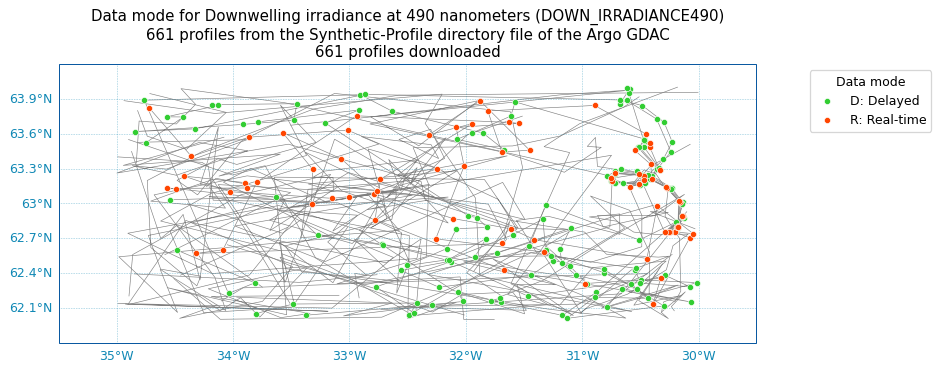

In [ ]:
# Finally plot the map:
fig, ax, artist = scatter_map(df,
                        hue="%s_DM" % a_param,
                        cmap="data_mode",
                        markersize=24,
                        markeredgecolor='w',
                        traj_color='gray',
                        legend_title='Data mode')
ax.set_title("Data mode for %s (%s)\n%i profiles from the %s\n%i profiles downloaded" % (param_info['prefLabel'], a_param, 
                                                                           idx.N_MATCH, idx.convention_title, df.shape[0]));

**Rq**: If some points have no data mode in the above map, it simply means that these profiles have not the request parameters

## Plot 

### Utilities

We will be using the argopy scatter_plot method that has the following signature:

```
scatter_plot(
    ds: xarray.core.dataset.Dataset,
    this_param,
    this_x='TIME',
    this_y='PRES',
    figsize=(18, 6),
    cmap=None,
    vmin=None,
    vmax=None,
    s=4,
)
```

In [ ]:
# Try to define readible color bounds for each BGC variables 
# (this is probably NOT appropriate for all regions and periods !)
c_bounds = {'BBP700': (20e-5, 70e-5),
            'CDOM': (0.4, 0.8),
            'CHLA': (0, 0.2),
            'DOWNWELLING_PAR': (0, 10),
            'DOWN_IRRADIANCE380': (0, .1),
            'DOWN_IRRADIANCE412': (0, .1),
            'DOWN_IRRADIANCE490': (0, .1),
            'DOXY': (250,300),
            'NITRATE': (-2, 20),
            'PH_IN_SITU_TOTAL': (6, 8.5),
           }

In [ ]:
# We''l make use of the argopy color scheme:
ArgoColors('qc')

### Plot some data QC

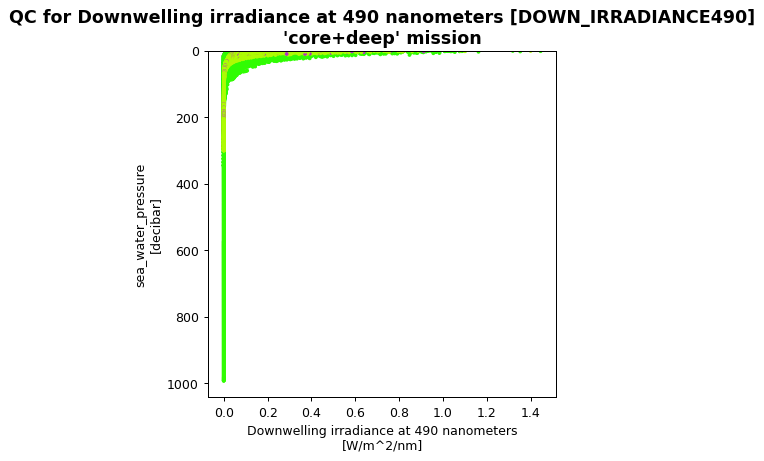

In [ ]:
fig, ax, artist = scatter_plot(ds, a_param + '_QC', this_x = a_param, 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param, f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

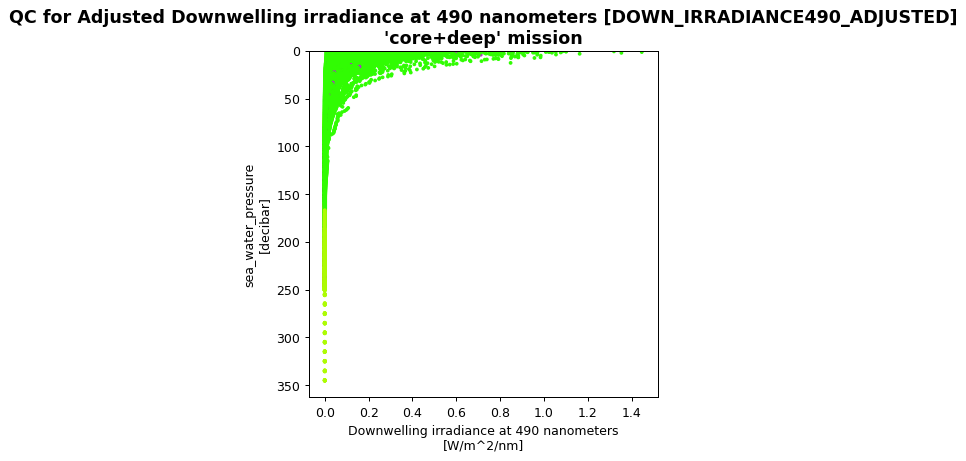

In [ ]:
fig, ax, artist = scatter_plot(ds, a_param + '_ADJUSTED_QC', this_x = a_param + '_ADJUSTED', 
                       vmin=0, vmax=9, cmap=ArgoColors('qc').cmap, figsize=(5,5))
ax.set_title("QC for Adjusted %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param + '_ADJUSTED', f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

### Plot some variable against another

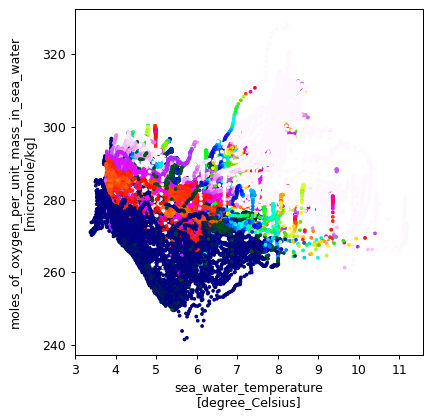

In [ ]:
fig, ax, artist = scatter_plot(ds, 'CHLA_ADJUSTED', this_x = 'TEMP_ADJUSTED', this_y = 'DOXY_ADJUSTED', figsize=(5,5))

### Plot time series

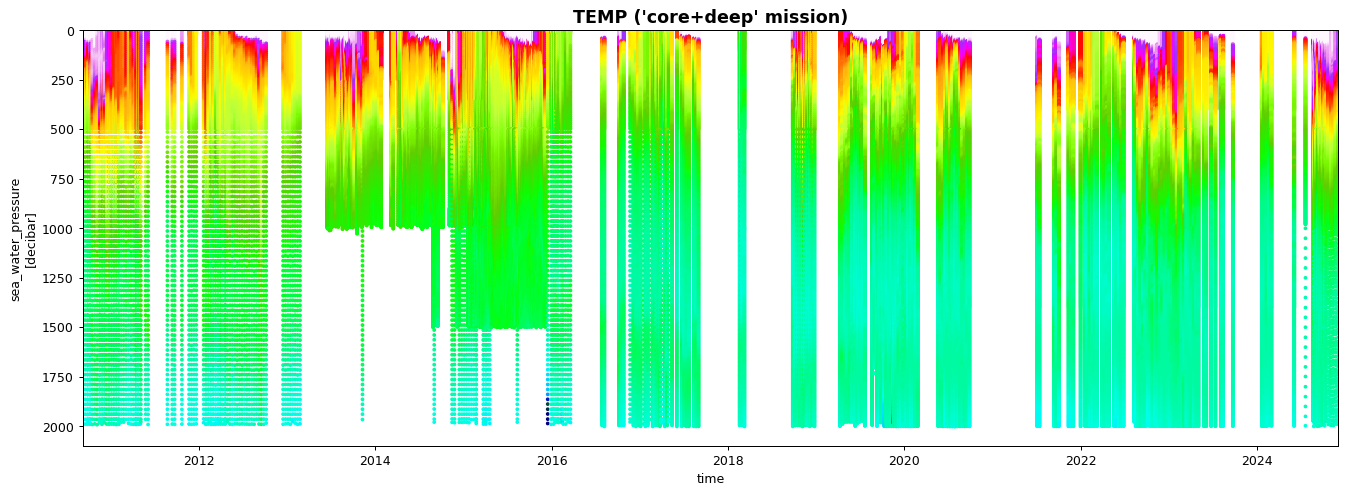

In [ ]:
fig, ax, artist = scatter_plot(ds, 'TEMP', vmin=2, vmax=8)
ax.set_title("%s ('%s' mission)" % ('TEMP', f.mission), fontdict={'weight': 'bold', 'size': 14});

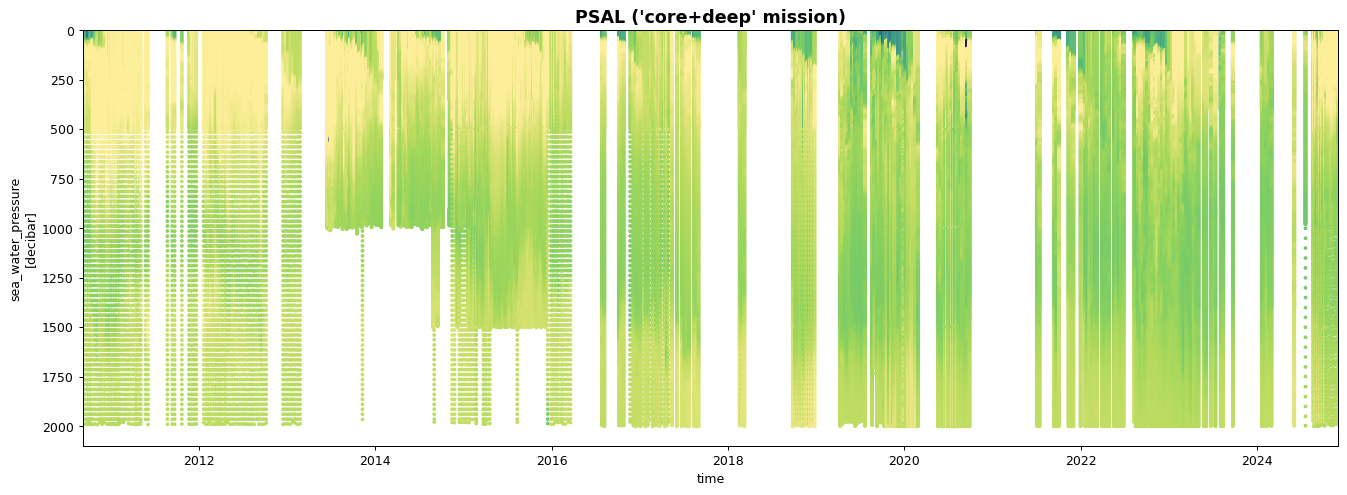

In [ ]:
fig, ax, artist = scatter_plot(ds, 'PSAL', cmap=cmocean.cm.haline, vmin=34.5, vmax=35)
ax.set_title("%s ('%s' mission)" % ('PSAL', f.mission), fontdict={'weight': 'bold', 'size': 14});

KeyError: "No variable named 'CHLA_FLUORESCENCE'. Variables on the dataset include [np.str_('BBP700'), np.str_('BBP700_ADJUSTED'), np.str_('BBP700_ADJUSTED_ERROR'), np.str_('BBP700_ADJUSTED_QC'), np.str_('BBP700_DATA_MODE'), ..., np.str_('TIME_QC'), 'LATITUDE', 'LONGITUDE', 'TIME', 'N_POINTS']"

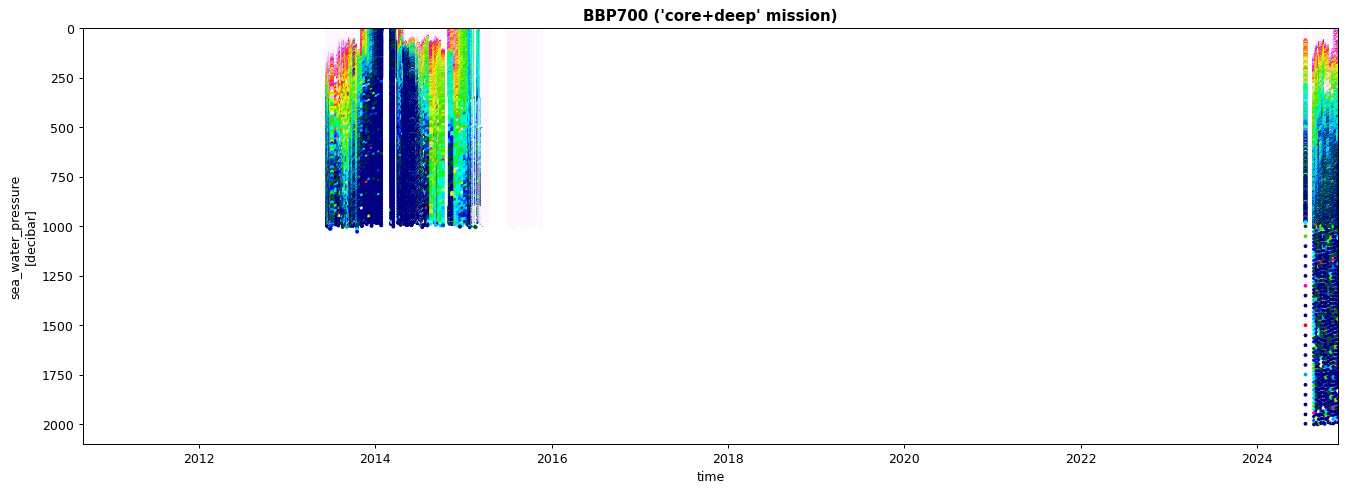

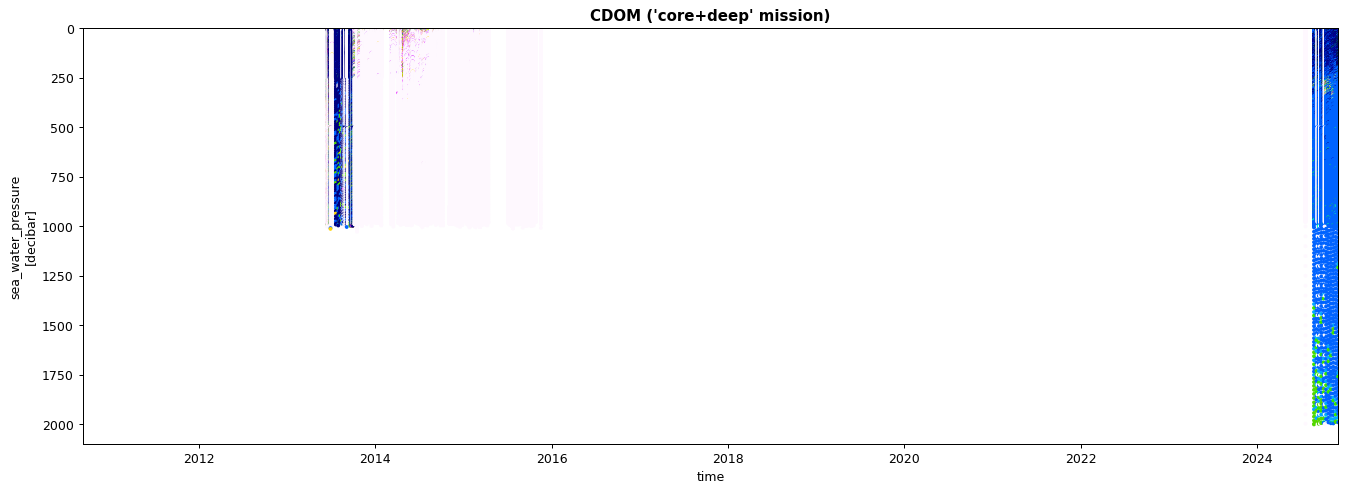

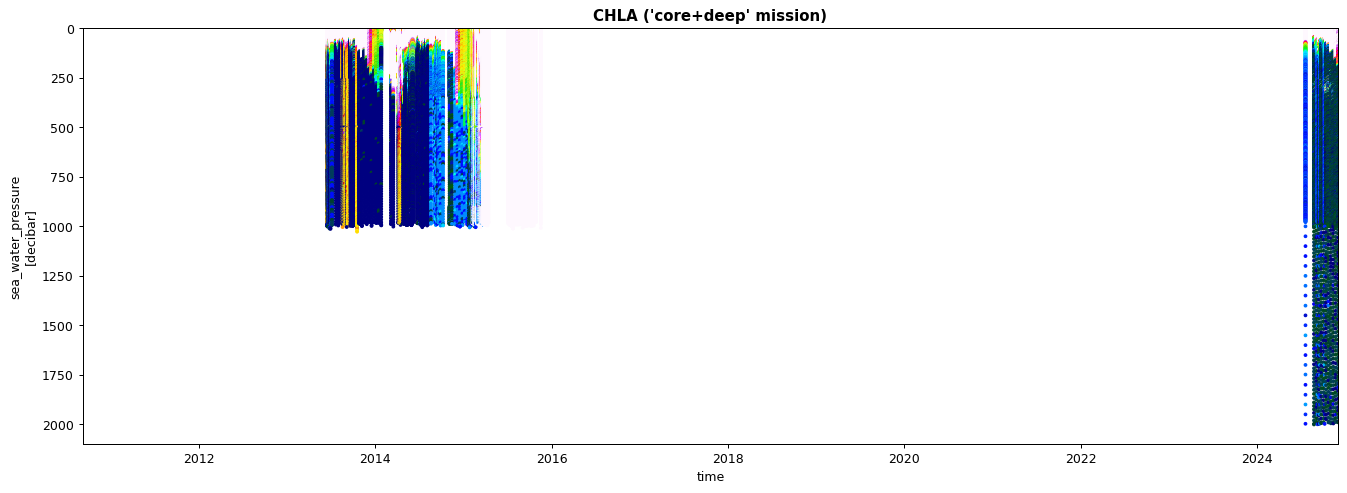

In [ ]:
# Plot all BGC params
for param in bgc_params:
    vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)    
    fig, ax, artist = scatter_plot(ds, param, vmin=vmin, vmax=vmax)
    ax.set_title("%s ('%s' mission)" % (param, f.mission), fontdict={'weight': 'bold', 'size': 12});